Databricks:
* Runtime: `11.1 ML (includes Apache Spark 3.3.0, Scala 2.12)`
* Cluster mode: `Single Node`
* Specs: `m5n.8xlarge 128 GB Memory, 32 Cores`

In [ ]:
import os
import tensorflow as tf
import torch
import transformers

print(f'TF Version: {tf.__version__}')
print(f'PT Version: {torch.__version__}')
print(f'HF Version: {transformers.__version__}')

TF Version: 2.9.1
PT Version: 1.11.0+cpu
HF Version: 4.20.0


Most users have their datasets hosted in S3 or DBFS when they are using Databricks. However, HuggingFace doesn't support these file systems.

* You can copy your files from DBFS to local file system (FileStore or driver) but this will take forever! (I mean forever!)
    * cp -r dbfs:/maziyar/datasets/imagenet-mini-sample/ file:/FileStore/imagenet-mini-sample
    * cp -r dbfs:/maziyar/datasets/imagenet-mini/ file:/FileStore/imagenet-mini
- Or you can download the files, zip them, upload them on S3, make them public, and download them in your local file system in Databricks. (yep, that's a very tedious way of using HuggingFace in Databricks for production)

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini-sample.zip && unzip /databricks/driver/imagenet-mini-sample.zip >/dev/null 2>&1
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini.zip && unzip /databricks/driver/imagenet-mini.zip >/dev/null 2>&1

In [ ]:
from PIL import Image
from tqdm.notebook import tqdm
from fnmatch import fnmatch
from timeit import default_timer as timer

pattern = "*.JPEG"

all_images_sample = []
folders = ["file:/databricks/driver/imagenet-mini-sample"]
while len(folders) > 0:
  current_folder = folders.pop(0)
  for file in dbutils.fs.ls(current_folder):
    name = file.path.split("/")[-1]
    if fnmatch(name, pattern):
      all_images_sample.append(file.path.replace("file:", ""))
      
      
all_images = []
folders = ["file:/databricks/driver/imagenet-mini"]
while len(folders) > 0:
  current_folder = folders.pop(0)
  for file in dbutils.fs.ls(current_folder):
    name = file.path.split("/")[-1]
    if fnmatch(name, pattern):
      all_images.append(file.path.replace("file:", ""))

print(f'total number of images: {len(all_images)}')
print(f'total number of sample images: {len(all_images_sample)}')

total number of images: 34745
total number of sample images: 3544


In [ ]:
all_images_sample[:1]

Out[5]: ['/databricks/driver/imagenet-mini-sample/n01751748_2297.JPEG']

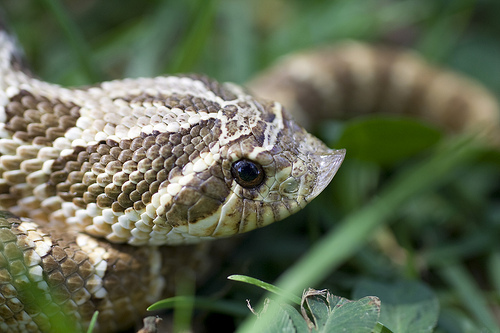

In [ ]:
Image.open('/databricks/driver/imagenet-mini-sample/n01729322_18506.JPEG')

# PyTorch CPU

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __len__(self):
        return len(all_images_sample)

    def __getitem__(self, i):
        return all_images_sample[i]

dataset = MyDataset()

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=-1)
    
for batch_size in [1, 8, 32, 64, 128]:
    print("-" * 30)
    print(f"Streaming batch_size={batch_size}")
    for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
        pass


- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)
<img src="image/databricks - hf - mini - torch - cpu.png" width="800">

### Larger Dataset on CPU

In [ ]:
class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]

dataset = MyDataset()

In [ ]:
batch_size = 8

print(f"Streaming batch_size={batch_size}")
for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
    pass
  

- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)
<img src="image/databricks - hf - full - torch - cpu.png" width="800">

In [ ]:
%sh
lscpu
free -h
nvidia-smi

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          32
On-line CPU(s) list:             0-31
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
Stepping:                        7
CPU MHz:                         3101.992
BogoMIPS:                        4999.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       512 KiB
L1i cache:                       512 KiB
L2 cache:                        16 MiB
L3 cache:                        35.8 MiB
NUMA node0 CPU(s):           

# PyTorch GPU

Attaching this notebook to the runtime with the following specs to run benchmarks on GPU
Databricks:
* Runtime: `11.1 ML (includes Apache Spark 3.3.0, GPU, Scala 2.12)`
* Cluster mode: `Single Node`
* Specs: `g4dn.8xlarge 128 GB Memory, 1 GPU`

- Since we are attached to another cluster we have to re-download and re-extract the datasets again 
- This is a tedious part that wouldn't be required if DBFS/S3 was supported in Hugging Face

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini-sample.zip && unzip /databricks/driver/imagenet-mini-sample.zip >/dev/null 2>&1
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini.zip && unzip /databricks/driver/imagenet-mini.zip >/dev/null 2>&1

In [ ]:
from PIL import Image
from tqdm.notebook import tqdm
from fnmatch import fnmatch
from timeit import default_timer as timer

pattern = "*.JPEG"

all_images_sample = []
folders = ["file:/databricks/driver/imagenet-mini-sample"]
while len(folders) > 0:
  current_folder = folders.pop(0)
  for file in dbutils.fs.ls(current_folder):
    name = file.path.split("/")[-1]
    if fnmatch(name, pattern):
      all_images_sample.append(file.path.replace("file:", ""))
      
      
all_images = []
folders = ["file:/databricks/driver/imagenet-mini"]
while len(folders) > 0:
  current_folder = folders.pop(0)
  for file in dbutils.fs.ls(current_folder):
    name = file.path.split("/")[-1]
    if fnmatch(name, pattern):
      all_images.append(file.path.replace("file:", ""))

print(f'total number of images: {len(all_images)}')
print(f'total number of sample images: {len(all_images_sample)}')

total number of images: 34745
total number of sample images: 3544


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

from torch.utils.data import Dataset

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model = model.to(device)


In [ ]:
class MyDataset(Dataset):
    def __len__(self):
        return len(all_images_sample)

    def __getitem__(self, i):
        return all_images_sample[i]


dataset = MyDataset()


In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=0)

for batch_size in [1, 8, 32, 64, 128, 256, 512, 1024]:
    print("-" * 30)
    print(f"Streaming batch_size={batch_size}")
    for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
        pass


- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)
<img src="image/databricks - hf - mini - torch - gpu.png" width="800">

In [ ]:
class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]

dataset = MyDataset()

In [ ]:
batch_size = 256

print(f"Streaming batch_size={batch_size}")
for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
    pass

- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)
<img src="image/databricks - hf - full - torch - gpu.png" width="800">

In [ ]:
%sh
lscpu
free -h
nvidia-smi

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          32
On-line CPU(s) list:             0-31
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
Stepping:                        7
CPU MHz:                         3102.312
BogoMIPS:                        4999.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       512 KiB
L1i cache:                       512 KiB
L2 cache:                        16 MiB
L3 cache:                        35.8 MiB
NUMA node0 CPU(s):           